# ETL

In [4]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

dataset:pd.DataFrame = pd.read_csv("S&P 500/sp500_index.csv")
dataset_exog:pd.DataFrame = pd.read_csv("S&P 500/sp500_stocks.csv")
companies = ["AAPL", "MSFT", "AMZN", "BRK-B", "JNJ", "JPM", "XOM",  "GOOG", "GOOGL"]
dataset_exog = dataset_exog[dataset_exog['Symbol'].isin(companies)]
dataset_exog['Date'] = pd.to_datetime(dataset_exog['Date'])
dataset_exog = dataset_exog[dataset_exog['Date'] >= datetime(year = 2012,month = 11,day = 12)]
exogenous = dataset_exog[['Date', 'Symbol', 'Close', 'High', 'Low', 'Volume']].dropna()
exogenous_c = dataset_exog[['Date', 'Symbol', 'Close']].dropna()
# Ripulire il dataset da valori nulli e simili
dataset = dataset.dropna()
#dataset = dataset.interpolate()
dataset.columns = ['data', 'sp500']
dataset['data'] = pd.to_datetime(dataset['data'])
dataset = dataset.set_index('data')
exogenous = exogenous.set_index('Date')
exogenous_c = exogenous_c.set_index('Date')
exogenous_close_only = exogenous_c.pivot_table(index=['Date'], 
            columns=['Symbol'], values='Close').fillna(0)
exogenous_close_only.drop(index=exogenous_c.index[-1],axis=0,inplace=True)

In [5]:
lag_features = []
exogenous_complete=exogenous[~exogenous.index.duplicated(keep="first")]
for company in companies:
    single_company_vals = exogenous[exogenous['Symbol']==company]
    single_company_vals.drop(columns=['Symbol'], inplace=True)
    single_company_vals.rename(columns={"Close":f"Close_{company}", "High":f"High_{company}", "Low":f"Low_{company}", "Volume":f"Volume_{company}"}, inplace=True)
    exogenous_complete = pd.concat([exogenous_complete, single_company_vals], axis=1)
    [lag_features.append(x) for x in list(single_company_vals.columns)]

exogenous_complete.drop(columns=['Symbol', 'High', 'Low', 'Close', 'Volume'], inplace=True)
exogenous_complete = exogenous_complete[:-1]
print(exogenous_complete)


            Close_AAPL   High_AAPL    Low_AAPL   Volume_AAPL  Close_MSFT  \
Date                                                                       
2012-11-12   19.386786   19.803572   19.237499  5.158020e+08   28.219999   
2012-11-13   19.389286   19.660000   19.155714  5.329492e+08   27.090000   
2012-11-14   19.174286   19.551786   19.149286  4.771704e+08   26.840000   
2012-11-15   18.772142   19.267857   18.665001  7.899108e+08   26.660000   
2012-11-16   18.845715   18.928572   18.062500  1.266894e+09   26.520000   
...                ...         ...         ...           ...         ...   
2022-11-03  138.880005  142.800003  138.750000  9.791850e+07  214.250000   
2022-11-04  138.380005  142.669998  134.380005  1.407167e+08  221.389999   
2022-11-07  138.919998  139.149994  135.669998  8.337460e+07  227.869995   
2022-11-08  139.500000  141.429993  137.490005  8.990850e+07  228.869995   
2022-11-09  134.869995  138.550003  134.589996  7.491780e+07  224.509995   

           

/tmp/ipykernel_6376/2827595455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_company_vals.drop(columns=['Symbol'], inplace=True)
/tmp/ipykernel_6376/2827595455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_company_vals.rename(columns={"Close":f"Close_{company}", "High":f"High_{company}", "Low":f"Low_{company}", "Volume":f"Volume_{company}"}, inplace=True)
/tmp/ipykernel_6376/2827595455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [6]:
df= exogenous_complete.copy()

df.reset_index(drop=True, inplace=True)
window1 = 3
window2 = 7
window3 = 31
window4 = 60
#window5 = 180
#window6 = 360

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
df_rolled_60d = df[lag_features].rolling(window=window4, min_periods=0)
#df_rolled_180d = df[lag_features].rolling(window=window5, min_periods=0)
#df_rolled_360d = df[lag_features].rolling(window=window5, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)
df_mean_60d = df_rolled_60d.mean().shift(1).reset_index().astype(np.float32)
#df_mean_180d = df_rolled_180d.mean().shift(1).reset_index().astype(np.float32)
#df_mean_360d = df_rolled_360d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)
df_std_60d = df_rolled_60d.std().shift(1).reset_index().astype(np.float32)
#df_std_180d = df_rolled_180d.std().shift(1).reset_index().astype(np.float32)
#df_std_360d = df_rolled_360d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window4}"] = df_mean_60d[feature]
#    df[f"{feature}_mean_lag{window5}"] = df_mean_180d[feature]
#    df[f"{feature}_mean_lag{window6}"] = df_mean_180d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window4}"] = df_std_60d[feature]
#    df[f"{feature}_std_lag{window5}"] = df_std_180d[feature]
#    df[f"{feature}_std_lag{window6}"] = df_std_180d[feature]

df.fillna(df.mean(), inplace=True)
df.index = exogenous_complete.index
exogenous_complete = df
df.head()
exog_list_30d = [s for s in exogenous_complete.columns.to_list() if 'lag31' in s]
[exog_list_30d.append(s) for s in exogenous_complete.columns.to_list() if 'lag60' in s]
print(exog_list_30d)

/tmp/ipykernel_6376/943398847.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feature}_mean_lag{window4}"] = df_mean_60d[feature]
/tmp/ipykernel_6376/943398847.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
/tmp/ipykernel_6376/943398847.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

['Close_AAPL_mean_lag31', 'Close_AAPL_std_lag31', 'High_AAPL_mean_lag31', 'High_AAPL_std_lag31', 'Low_AAPL_mean_lag31', 'Low_AAPL_std_lag31', 'Volume_AAPL_mean_lag31', 'Volume_AAPL_std_lag31', 'Close_MSFT_mean_lag31', 'Close_MSFT_std_lag31', 'High_MSFT_mean_lag31', 'High_MSFT_std_lag31', 'Low_MSFT_mean_lag31', 'Low_MSFT_std_lag31', 'Volume_MSFT_mean_lag31', 'Volume_MSFT_std_lag31', 'Close_AMZN_mean_lag31', 'Close_AMZN_std_lag31', 'High_AMZN_mean_lag31', 'High_AMZN_std_lag31', 'Low_AMZN_mean_lag31', 'Low_AMZN_std_lag31', 'Volume_AMZN_mean_lag31', 'Volume_AMZN_std_lag31', 'Close_BRK-B_mean_lag31', 'Close_BRK-B_std_lag31', 'High_BRK-B_mean_lag31', 'High_BRK-B_std_lag31', 'Low_BRK-B_mean_lag31', 'Low_BRK-B_std_lag31', 'Volume_BRK-B_mean_lag31', 'Volume_BRK-B_std_lag31', 'Close_JNJ_mean_lag31', 'Close_JNJ_std_lag31', 'High_JNJ_mean_lag31', 'High_JNJ_std_lag31', 'Low_JNJ_mean_lag31', 'Low_JNJ_std_lag31', 'Volume_JNJ_mean_lag31', 'Volume_JNJ_std_lag31', 'Close_JPM_mean_lag31', 'Close_JPM_std_

# Data Visualization

In [7]:
exogenous_complete

,Close_AAPL,High_AAPL,Low_AAPL,Volume_AAPL,Close_MSFT,High_MSFT,Low_MSFT,Volume_MSFT,Close_AMZN,High_AMZN,...,Low_GOOGL_std_lag31,Low_GOOGL_std_lag60,Volume_GOOGL_mean_lag3,Volume_GOOGL_mean_lag7,Volume_GOOGL_mean_lag31,Volume_GOOGL_mean_lag60,Volume_GOOGL_std_lag3,Volume_GOOGL_std_lag7,Volume_GOOGL_std_lag31,Volume_GOOGL_std_lag60
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-12,19.386786,19.803572,19.237499,5.158020e+08,28.219999,29.010000,28.209999,61112300.0,11.323500,11.461000,...,1.905657,2.620576,43622848.0,43636420.0,43842356.0,44171164.0,10166462.0,13003051.0,17358904.0,18905918.0
2012-11-13,19.389286,19.660000,19.155714,5.329492e+08,27.090000,27.299999,26.750000,131689200.0,11.330000,11.395000,...,1.905657,2.620576,56179764.0,56179764.0,56179764.0,56179764.0,10166462.0,13003051.0,17358904.0,18905918.0
2012-11-14,19.174286,19.551786,19.149286,4.771704e+08,26.840000,27.290001,26.799999,76086100.0,11.147500,11.370500,...,0.046716,0.046716,59942000.0,59942000.0,59942000.0,59942000.0,5320602.5,5320602.5,5320602.5,5320602.5
2012-11-15,18.772142,19.267857,18.665001,7.899108e+08,26.660000,26.969999,26.629999,50955600.0,11.030000,11.258000,...,0.134864,0.134864,62184420.0,62184420.0,62184420.0,62184420.0,5407381.5,5407381.5,5407381.5,5407381.5
2012-11-16,18.845715,18.928572,18.062500,1.266894e+09,26.520000,26.700001,26.340000,64083300.0,11.261500,11.312500,...,0.192648,0.192648,68085184.0,65108824.0,65108824.0,65108824.0,5234556.0,7328150.0,7328150.0,7328150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-03,138.880005,142.800003,138.750000,9.791850e+07,214.250000,220.410004,213.979996,36633900.0,89.300003,93.500000,...,3.286402,8.562427,45291568.0,52715484.0,33437688.0,29348266.0,12784618.0,18425804.0,13943747.0,11723237.0
2022-11-04,138.380005,142.669998,134.380005,1.407167e+08,221.389999,221.589996,213.429993,36767800.0,90.980003,92.440002,...,4.048582,8.722693,55162568.0,55669284.0,34399000.0,29854226.0,7247688.5,17809016.0,14805439.0,12426670.0
2022-11-07,138.919998,139.149994,135.669998,8.337460e+07,227.869995,228.410004,221.279999,33498000.0,90.529999,92.099998,...,4.608226,8.822854,56477300.0,50382356.0,34941160.0,30301092.0,5114328.5,10610264.0,15106311.0,12702346.0


In [8]:
exogenous_close_only

Symbol,AAPL,AMZN,BRK-B,GOOG,GOOGL,JNJ,JPM,MSFT,XOM
Date,,,,,,,,,
2012-11-12,19.386786,11.323500,85.269997,16.585335,16.664164,69.680000,40.580002,28.219999,87.320000
2012-11-13,19.389286,11.330000,85.870003,16.414724,16.492743,69.510002,40.040001,27.090000,86.470001
2012-11-14,19.174286,11.147500,84.879997,16.252831,16.330080,69.269997,39.290001,26.840000,86.070000
2012-11-15,18.772142,11.030000,85.300003,16.121075,16.197699,69.070000,39.389999,26.660000,86.139999
2012-11-16,18.845715,11.261500,85.910004,16.119081,16.195696,69.190002,39.529999,26.520000,86.449997
...,...,...,...,...,...,...,...,...,...
2022-11-03,138.880005,89.300003,283.850006,83.489998,83.430000,170.720001,127.199997,214.250000,111.099998
2022-11-04,138.380005,90.980003,287.470001,86.699997,86.580002,171.479996,130.679993,221.389999,112.309998
2022-11-07,138.919998,90.529999,290.190002,88.650002,88.489998,172.979996,131.369995,227.869995,113.639999


<Axes: xlabel='data'>

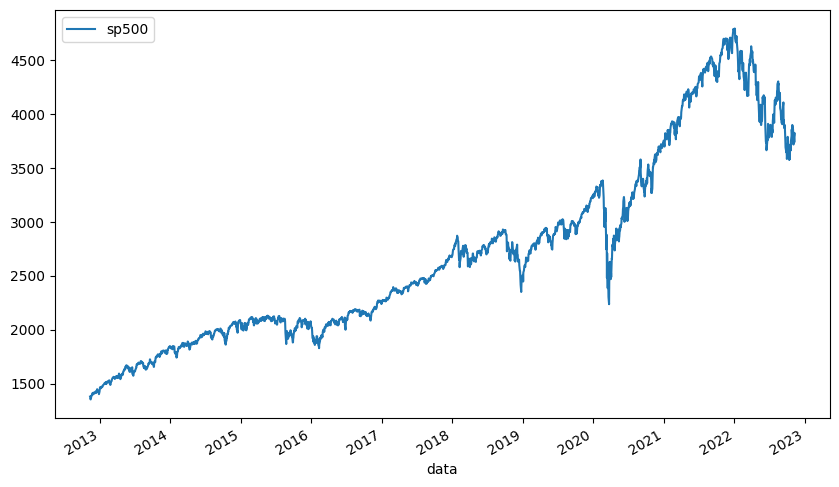

In [18]:
dataset.plot(legend=True, figsize=(10,6))

<Axes: xlabel='Date'>

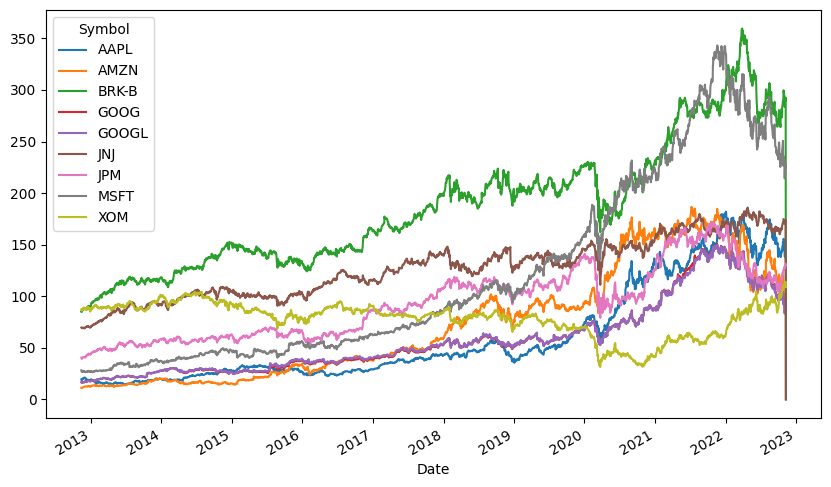

In [17]:
exogenous_close_only.plot(figsize=(10,6))

# Analisi della serie

In [19]:
# ADF test per capire se la serie è stazionaria o meno
adf_test_results = adfuller(dataset.sp500)

# Controllare il p-value per del risultato per capire se la serie sia stazionaria
print(f"ADF Statistic: {adf_test_results[0]}")
print(f"p-value: {adf_test_results[1]}")

ADF Statistic: -1.0212412028824256
p-value: 0.7454384431334125


<Axes: xlabel='data'>

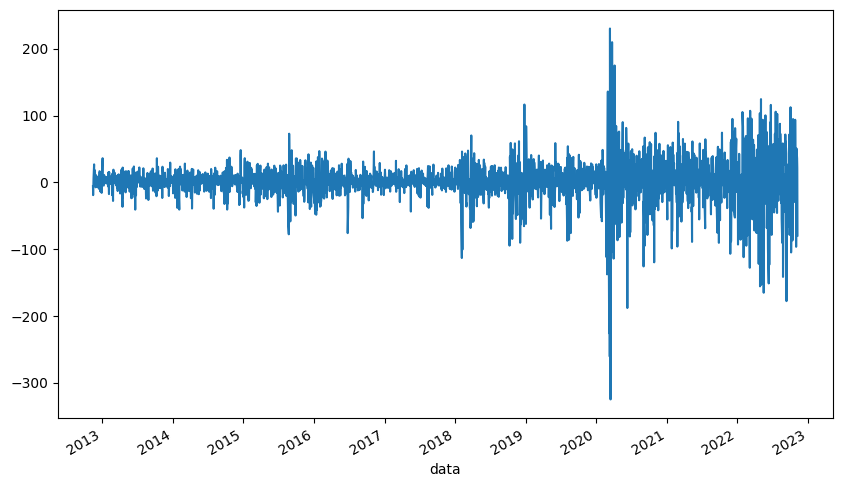

In [20]:
# La serie non è stazionaria
differentiated = dataset.copy()
differentiated.sp500=differentiated.sp500.diff()
differentiated=differentiated.dropna()
differentiated.sp500.plot(figsize=(10,6))

In [22]:
# Si controlla se la nuova serie differenziata
adf_test_results = adfuller(differentiated.sp500)

print(f"ADF Statistic: {adf_test_results[0]}")
print(f"p-value: {adf_test_results[1]}")

# Il p-value è basso --> la serie è stazionaria con una sola differenziazione
d=1

ADF Statistic: -10.568001065894565
p-value: 7.430229545588812e-19


/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


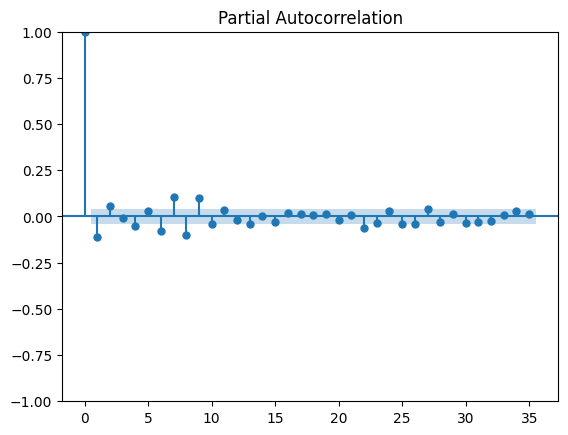

In [23]:
# Ora si controlla l'auto-correlazione parziale
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(differentiated.sp500)
p=2

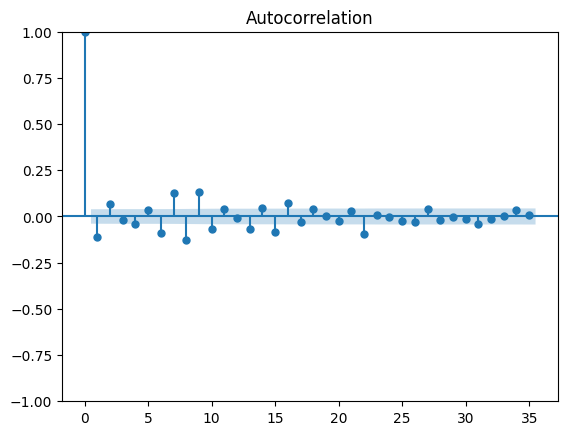

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(differentiated.sp500)
q=2

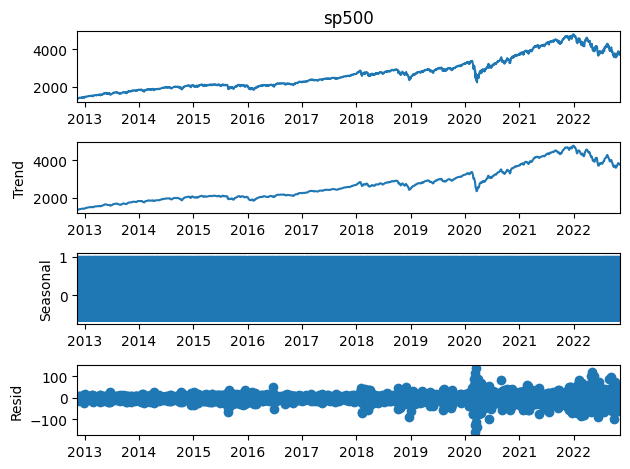

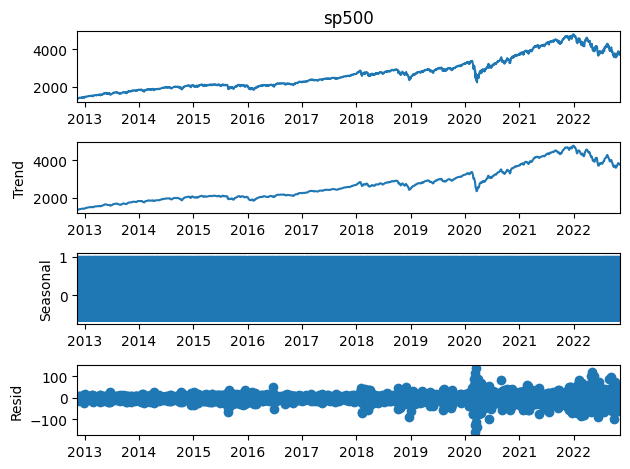

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(dataset.sp500, period=5).plot()

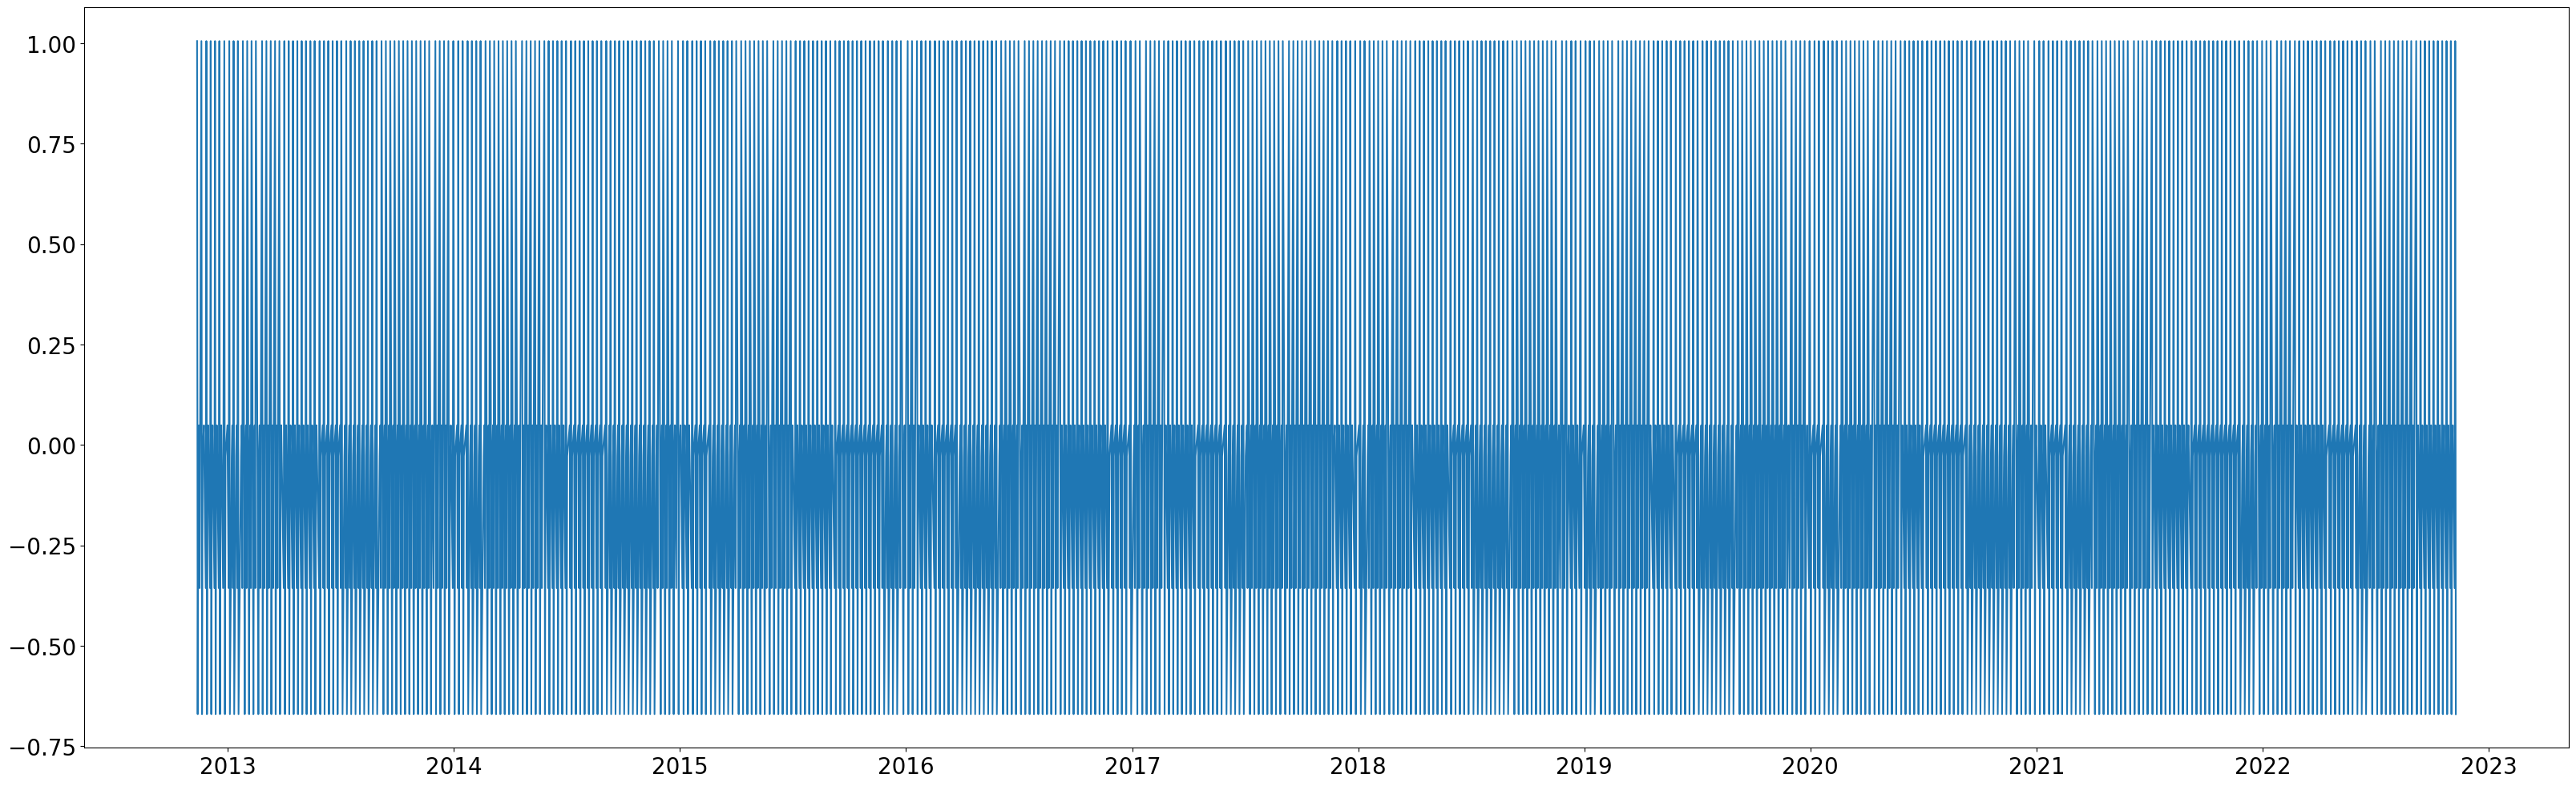

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
figure = plt.gcf()
figure.set_size_inches(40,12)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(seasonal_decompose(dataset.sp500, period=5).seasonal)

# Costruzione dei modelli e predizione

In [32]:
dataset_SARIMAX = dataset.copy()
dataset_SARIMAX.index = pd.DatetimeIndex(dataset_SARIMAX.index).to_period('D') 
exogenous_for_prediction = exogenous_close_only.copy()
exogenous_for_prediction.index = pd.DatetimeIndex(exogenous_for_prediction.index).to_period('D') 

In [25]:
from datetime import date, timedelta

start = date(year=2022, month=11, day=9)
end = date(year=2022, month=12, day=21)

# get list of all days
all_days = [start + timedelta(x) for x in range((end - start).days)]
business_days = list(filter(lambda x: x.weekday()<5, all_days))
print(len(business_days))

30


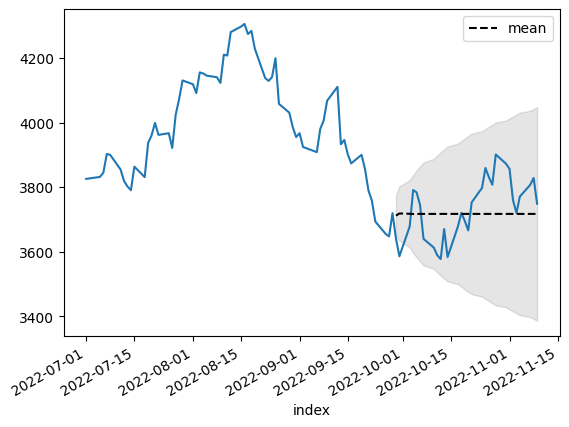

In [26]:
from statsmodels.tsa.arima.model import ARIMA
dataset_ARIMA = dataset.copy()
dataset_ARIMA.index = pd.DatetimeIndex(dataset_ARIMA.index).to_period('D') 
model = ARIMA(dataset_ARIMA[:-30], order=(p,d,q))
model_fit=model.fit()
fcasting = model_fit.get_forecast(30).summary_frame()
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2022, month=7, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": dataset_ARIMA[-30:].index}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": dataset_ARIMA[-30:].index}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": dataset_ARIMA[-30:].index}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

In [27]:
from datetime import date, timedelta

start = date(year=2022, month=9, day=29)
end = date(year=2022, month=11, day=10)

# get list of all days
all_days_2 = [start + timedelta(x) for x in range((end - start).days)]
business_days_2 = list(filter(lambda x: x.weekday()<5, all_days_2))
print(len(business_days_2))
print(business_days_2)

30
[datetime.date(2022, 9, 29), datetime.date(2022, 9, 30), datetime.date(2022, 10, 3), datetime.date(2022, 10, 4), datetime.date(2022, 10, 5), datetime.date(2022, 10, 6), datetime.date(2022, 10, 7), datetime.date(2022, 10, 10), datetime.date(2022, 10, 11), datetime.date(2022, 10, 12), datetime.date(2022, 10, 13), datetime.date(2022, 10, 14), datetime.date(2022, 10, 17), datetime.date(2022, 10, 18), datetime.date(2022, 10, 19), datetime.date(2022, 10, 20), datetime.date(2022, 10, 21), datetime.date(2022, 10, 24), datetime.date(2022, 10, 25), datetime.date(2022, 10, 26), datetime.date(2022, 10, 27), datetime.date(2022, 10, 28), datetime.date(2022, 10, 31), datetime.date(2022, 11, 1), datetime.date(2022, 11, 2), datetime.date(2022, 11, 3), datetime.date(2022, 11, 4), datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9)]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58009D+00    |proj g|=  1.24396D-01


 This problem is unconstrained.



At iterate    5    f=  3.58007D+00    |proj g|=  8.93119D-01

At iterate   10    f=  3.57995D+00    |proj g|=  1.13260D-02

At iterate   15    f=  3.57995D+00    |proj g|=  1.45496D-01

At iterate   20    f=  3.57993D+00    |proj g|=  3.62499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     21     39      1     0     0   3.625D-02   3.580D+00
  F =   3.5799258748832794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


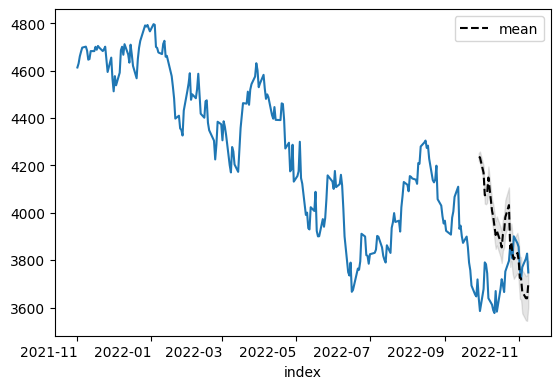

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX = dataset.copy()
dataset_SARIMAX.index = pd.DatetimeIndex(dataset_SARIMAX.index).to_period('D')
model_sarimax = SARIMAX(dataset_SARIMAX[:-30], order=(p,d,q), exog=exogenous_for_prediction[:-30], trend='ct')
model_fit = model_sarimax.fit()
fcasting = model_fit.get_forecast(30, exog=exogenous_for_prediction[-60:-30]).summary_frame()
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2021, month=11, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": business_days_2}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": business_days_2}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": business_days_2}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82291D+00    |proj g|=  3.94380D+05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151      1     21      1     0     0   3.944D+05   4.823D+00
  F =   4.8229124588270977     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


sp500              mean     mean_se  mean_ci_lower  mean_ci_upper
2019-09-04  3823.786711   30.107203    3764.777677    3882.795745
2019-09-05  3798.099677   42.578015    3714.648301    3881.551053
2019-09-06  3812.074062   52.147206    3709.867417    3914.280707
2019-09-07  3820.174880   60.214407    3702.156812    3938.192948
2019-09-08  3822.733934   67.321753    3690.785723    3954.682146
2019-09-09  3824.556493   73.747286    3680.014469    3969.098517
2019-09-10  3814.144521   79.656173    3658.021291    3970.267750
2019-09-11  3780.057900   85.156030    3613.155147    3946.960653
2019-09-12  3766.528952   90.321610    3589.501849    3943.556054
2019-09-13  3751.655414   95.207336    3565.052463    3938.258364
2019-09-14  3742.425950   99.854297    3546.715125    3938.136775
2019-09-15  3762.500601  104.294411    3558.087310    3966.913891
2019-09-16  3754.406147  108.553065    3541.646049    3967.166245
2019-09-17  3792.250612  112.650840    3571.459024    4013.042201
2019-09-18

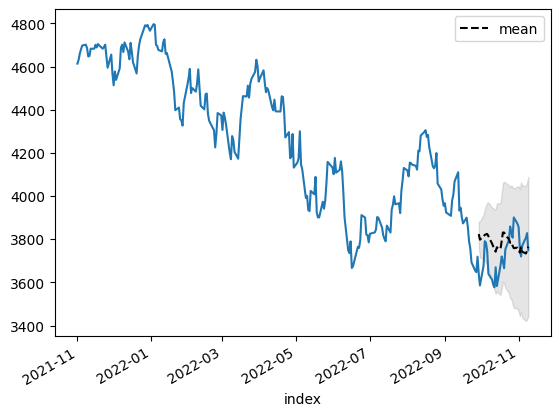

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX = dataset.copy()
dataset_SARIMAX.index = pd.DatetimeIndex(dataset_SARIMAX.index).to_period('D')
exogenous_2 = exogenous_complete.copy()
exogenous_2.index = pd.DatetimeIndex(exogenous_2.index).to_period('D')
model_sarimax = SARIMAX(dataset_SARIMAX[:-30], order=(p,d,q), exog=exogenous_2[:-30][exog_list_30d], trend='ct')
model_fit = model_sarimax.fit()
fcasting = model_fit.get_forecast(30, exog=exogenous_2[-60:-30][exog_list_30d]).summary_frame()
print(fcasting)
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2021, month=11, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83151D+00    |proj g|=  4.11967D+05


 This problem is unconstrained.
/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151      1     21      1     0     0   4.120D+05   4.832D+00
  F =   4.8315071608006317     

ABNORMAL_TERMINATION_IN_LNSRCH                              
sp500         mean     mean_se  mean_ci_lower  mean_ci_upper
2457   3716.433858   30.431994    3656.788245    3776.079471
2458   3727.547241   40.489977    3648.188345    3806.906137
2459   3743.556113   49.478712    3646.579619    3840.532607
2460   3756.549950   56.681812    3645.455640    3867.644261
2461   3763.133714   63.228592    3639.207950    3887.059477
2462   3770.255662   69.091556    3634.838700    3905.672

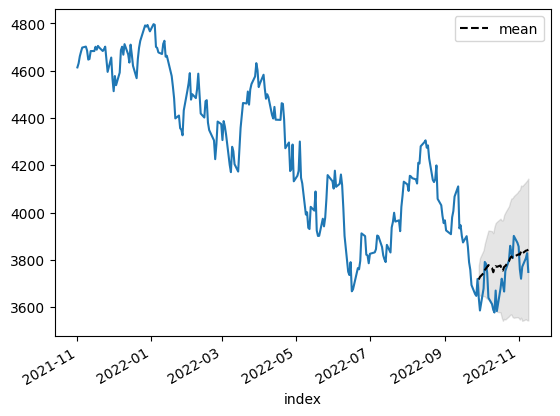

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX_2 = dataset_SARIMAX[30:-30].copy().reset_index(drop=True)
exogenous_2 = exogenous_complete.copy().reset_index(drop=True)
model_sarimax = SARIMAX(dataset_SARIMAX_2, order=(p,d,q), exog=exogenous_2[:-60][exog_list_30d], trend='ct')
model_fit = model_sarimax.fit()
fcasting = model_fit.get_forecast(30, exog=exogenous_2[-60:-30][exog_list_30d]).summary_frame()
print(fcasting)
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2021, month=11, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": dataset_SARIMAX.index[-30:]}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

# Previsioni out-of-sample

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84930D+00    |proj g|=  3.94805D+05


 This problem is unconstrained.
/home/lorenzo/python_venv/data_science/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151      1     21      1     0     0   3.948D+05   4.849D+00
  F =   4.8492984673540578     

ABNORMAL_TERMINATION_IN_LNSRCH                              
sp500         mean     mean_se  mean_ci_lower  mean_ci_upper
2487   3759.748224   30.969347    3699.049420    3820.447028
2488   3756.031301   41.217850    3675.245800    3836.816802
2489   3766.809235   50.100258    3668.614534    3865.003937
2490   3779.641448   57.102637    3667.722336    3891.560559
2491   3788.237245   63.501154    3663.777270    3912.697220
2492   3801.160882   69.187546    3665.555784    3936.765

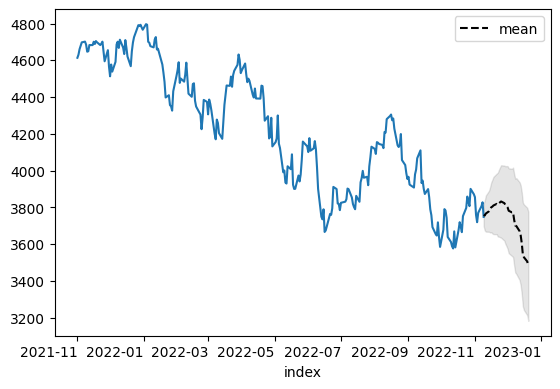

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX_2 = dataset_SARIMAX[30:].copy().reset_index(drop=True)
exogenous_2 = exogenous_complete.copy().reset_index(drop=True)
model_sarimax = SARIMAX(dataset_SARIMAX_2, order=(p,d,q), exog=exogenous_2[:-30][exog_list_30d], trend='ct')
model_fit = model_sarimax.fit()
fcasting = model_fit.get_forecast(30, exog=exogenous_2[-30:][exog_list_30d]).summary_frame()
print(fcasting)
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2021, month=11, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"]
mean = pd.DataFrame({"mean":mean, "index": business_days}).set_index('index')
mean_lower = fcasting["mean_ci_lower"]
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": business_days}).set_index('index')
mean_upper = fcasting["mean_ci_upper"]
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": business_days}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

In [39]:
# METRICHE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
test = dataset_SARIMAX[-30:]
forecast = mean
#mean absolute error
mae = mean_absolute_error(test, forecast)

#root mean square error
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

#mean absolute percentage error
mape = np.mean(np.abs((np.array(test) - np.array(forecast))/np.array(test)))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



MAE: 74.42
RMSE: 91.64
MAPE: 0.02%
